# Encoding the Audio

In [1]:
import sys 
import os 
import pickle 
import numpy as np
import spacy
import seaborn as sns
import matplotlib as plt 
import matplotlib.pyplot as plt 
import pandas as pd

sys.path.append(os.path.abspath("../lingpred_new/"))
from plotting import times_100, lowerCI, upperCI, reshape, colours
from encoding_analysis import make_arbitrary_static_vectors, brainscore
from utils import get_words_onsets_offsets, get_bigram_mask, make_y_matrix_per_run, get_runs, subsample_to_adjust_PoS

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [17]:
# select the dataset:
# -------------------
#dataset = 'Goldstein' # or 
dataset = 'Armeni'
#dataset = 'Gwilliams'

# type of audio data:
use_real_word_offsets = True

# dummy variables needed for that get_run functions
session = 1
subject = 1
task    = '0'

# Let's get the dataframe containing the words:
runs     = get_runs(dataset, session, subject, task)
words_df = pd.DataFrame() 
for run in runs:
    if len(runs)==1:
        words_df = get_words_onsets_offsets(dataset, subject=subject, session=session, run=run)
    else: 
        temp     = get_words_onsets_offsets(dataset, subject=subject, session=session, run=run)
        words_df = pd.concat([words_df, temp])
        
len(words_df)

8622

In [18]:
# load the appropriate acoustic model:

if use_real_word_offsets:     
    with open('../audio/{}/acoustic_model_8_mels_averaged_per_word_using_word_offsets.pkl'.format(dataset), 'rb') as f:
        acoustics = pickle.load(f)
else:   
    with open('../audio/{}/acoustic_model_8_mels_averaged_per_word_using_next_word_onset_as_offset.pkl'.format(dataset), 'rb') as f:
        acoustics = pickle.load(f)

acoustics.shape

(85719, 9)

In [19]:
'''
# Compute the indices for making the y matrix
# -------------------------------------------
# This is already saved under audio/<dataset>/indices_all_tasks.pkl
# No need to run this again, as this would take  approx. 10 min

indices = get_indices_per_task(dataset)
indices.shape

dir_path = '../audio/{}/'.format(dataset)
file_name = 'indices_all_tasks.pkl'
path      = dir_path + file_name

print(path)
f = open(path,"wb")
pickle.dump(indices, f)
f.close()

'''

# load the indices:
if dataset in ['Goldstein', 'Gwilliams']:
    with open('../audio/{}/indices_all_tasks.pkl'.format(dataset), 'rb') as f:
        indices = pickle.load(f)
if dataset == 'Armeni':
    with open('../audio/Armeni/indices_session_1.pkl', 'rb') as f:
        indices = pickle.load(f)


indices.shape

(8622, 157)

In [20]:
# use indices to make an acoustic y matrix of shape (length, 157, dim)
y_acoustics = make_y_matrix_per_run(acoustics, indices)
print('Acoustic y matrix of shape (length, 157, dimensionality)')
y_acoustics.shape

Acoustic y matrix of shape (length, 157, dimensionality)


(8622, 157, 9)

In [21]:
# Let us look at what our words dataframe looks like at the moment:
words_df.head(6)

,onset,duration,sample,type,word,offset
3,1.089189,0.129705,46637.372038,word_onset_01,THE,1.218895
6,1.218895,0.678458,46793.018296,word_onset_01,ADVENTURES,1.897353
15,1.897353,0.089796,47607.167956,word_onset_01,OF,1.987149
18,1.987149,0.488889,47714.923058,word_onset_01,SHERLOCK,2.476037
24,2.476037,0.698413,48301.589725,word_onset_01,HOLMES,3.174450
31,3.912772,0.149660,50025.671358,word_onset_01,A,4.062432


In [22]:
# make spacy doc of the text
nlp     = spacy.load('en_core_web_lg')
text    = " ".join(words_df["word"].astype(str))
doc     = nlp(text)

# since our doc is longer than our dataframe we have to match PoS to fit the dataframe
# (words like "there's" are two words in the doc but one in the dataframe)
matched_PoS = []
token_idx   = 0

for word in words_df['word']:
    # get the PoS of the current token
    if token_idx < len(doc):
        matched_PoS.append(doc[token_idx].pos_)
        # advance token_idx until the next word boundary
        token_idx += len(nlp(word))  # number of spaCy tokens in this word
    else:
        # fallback if doc ends unexpectedly
        matched_PoS.append(None)

len(matched_PoS), len(words_df)

(8622, 8622)

In [23]:
# amend the words dataframe with useful information:
words_df['duration']              = words_df['offset'] - words_df['onset']
words_df['duration previous word']= words_df['duration'].shift(1)
words_df['PoS']                   = matched_PoS
words_df['previous PoS']          = words_df['PoS'].shift(1)
words_df['word_index']            = np.arange(len(words_df)).astype(int)
words_df['word']                  = words_df['word'].astype('string')


# include information about the PoS type: content vs. non-content word:
content_pos = {'NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV'}

def map_content(pos):
    return 'Content' if pos in content_pos else 'Non-content'

# Apply mapping
words_df['previous PoS_type']   = words_df['previous PoS'].apply(map_content)

# avoid having NaNs (for the first word the duration of the previous words is undefined)
words_df.iloc[0, words_df.columns.get_loc('duration previous word')] = 0

# Let us look at what our words dataframe looks like at the moment:
words_df.head(6)

,onset,duration,sample,type,word,offset,duration previous word,PoS,previous PoS,word_index,previous PoS_type
3,1.089189,0.129705,46637.372038,word_onset_01,THE,1.218895,0.000000,DET,None,0,Non-content
6,1.218895,0.678458,46793.018296,word_onset_01,ADVENTURES,1.897353,0.129705,PROPN,DET,1,Non-content
15,1.897353,0.089796,47607.167956,word_onset_01,OF,1.987149,0.678458,ADP,PROPN,2,Content
18,1.987149,0.488889,47714.923058,word_onset_01,SHERLOCK,2.476037,0.089796,PROPN,ADP,3,Non-content
24,2.476037,0.698413,48301.589725,word_onset_01,HOLMES,3.174450,0.488889,PROPN,PROPN,4,Content
31,3.912772,0.149660,50025.671358,word_onset_01,A,4.062432,0.698413,DET,PROPN,5,Content


### Getting the X Matrices: GPT, GloVe and Arbitrary vectors

In [24]:

# Make X matrices for arbitrary vectors        
X_arbitrary  = make_arbitrary_static_vectors(words_df, dim=300)

# Get GloVe vectors:
X_Glove = np.vstack([nlp(word).vector for word in words_df.word]) # np array of shape (nr_words, 300)

# Get GPT vectors:
if dataset == 'Goldstein':  
    with open('../audio/Goldstein/X_GPT_original_and_residualised_layer_47.pkl', 'rb') as f:
        X_matrices_GPT     = pickle.load(f)
        X_GPT              = X_matrices_GPT['X_GPT_layer_47']
elif dataset == 'Armeni':
    with open('../audio/Armeni/X_y_matrices_Glove_GPT_arbitrary_session_1.pkl', 'rb') as f:
        X_matrices_GPT     = pickle.load(f)
        X_GPT              = X_matrices_GPT['X_GPT']

print('Arbitrary vectors have shape:', X_arbitrary.shape)
print('GloVe vectors have shape:', X_Glove.shape)
print('GPT vectors have shape:', X_GPT.shape)

Arbitrary vectors have shape: (8622, 300)
GloVe vectors have shape: (8622, 300)
GPT vectors have shape: (8622, 768)


### Audio Encoding: Main Effect

In [25]:
reoccuring_bigram_mask = get_bigram_mask(words_df)
reoccuring_bigram_mask.shape

       onset  duration        sample           type        word    offset  \
3   1.089189  0.129705  46637.372038  word_onset_01         THE  1.218895   
6   1.218895  0.678458  46793.018296  word_onset_01  ADVENTURES  1.897353   
15  1.897353  0.089796  47607.167956  word_onset_01          OF  1.987149   
18  1.987149  0.488889  47714.923058  word_onset_01    SHERLOCK  2.476037   
24  2.476037  0.698413  48301.589725  word_onset_01      HOLMES  3.174450   

    duration previous word    PoS previous PoS  word_index previous PoS_type  \
3                 0.000000    DET         None           0       Non-content   
6                 0.129705  PROPN          DET           1       Non-content   
15                0.678458    ADP        PROPN           2           Content   
18                0.089796  PROPN          ADP           3       Non-content   
24                0.488889  PROPN        PROPN           4           Content   

     next_word           bigram  
3   ADVENTURES   THE_A

(6366,)

In [26]:
# compute encoding for original GloVe and arbitrary vectors:
# ----------------------------------------------------------

# format the y matrix correctly:
y = y_acoustics
y = np.swapaxes(np.swapaxes(y, 0, 1), 0, 2)
print('y should be of shape: (nr_mels, nr_words, nr_timepoints')
print('y has shape ', y.shape)
print('-'*25)

# do encoding for 'full' vectors
encoding_arbitrary = brainscore(X_arbitrary, y)
encoding_Glove     = brainscore(X_Glove, y)
encoding_GPT       = brainscore(X_GPT, y)

# dropping the first row in the y matrix is done inside the brainscore_no_coef function, so we keep y as is
print('\n y should be of shape: (nr_mels, nr_words, nr_timepoints')
print('y has shape ', y.shape)
print('-'*25)

# do encoding for 'residual' vectors:
encoding_arbitrary_residualised = brainscore(X_arbitrary, y, residualise=True)
encoding_Glove_residualised     = brainscore(X_Glove, y, residualise=True)
encoding_GPT_residualised       = brainscore(X_GPT, y, residualise=True)

# do encoding for removing reoccuring bigrams:
y_no_bigrams                  = y_acoustics[reoccuring_bigram_mask]
y_no_bigrams                  = np.swapaxes(np.swapaxes(y_no_bigrams, 0, 1), 0, 2)
print('\n y should be of shape: (nr_mels, nr_words, nr_timepoints')
print('y has shape ', y_no_bigrams.shape)
print('-'*25)
X_arbitrary_no_bigrams        = X_arbitrary[reoccuring_bigram_mask]
encoding_arbitrary_no_bigrams = brainscore(X_arbitrary_no_bigrams, y_no_bigrams)

y should be of shape: (nr_mels, nr_words, nr_timepoints
y has shape  (9, 8622, 157)
-------------------------
We are now in the brainscore method, and y has shape:
(9, 8622, 157)
We are now in the brainscore method, and y has shape:
(9, 8622, 157)
We are now in the brainscore method, and y has shape:
(9, 8622, 157)

 y should be of shape: (nr_mels, nr_words, nr_timepoints
y has shape  (9, 8622, 157)
-------------------------
We are now in the brainscore method, and y has shape:
(9, 8622, 157)
We are now in the brainscore method, and y has shape:
(9, 8622, 157)
We are now in the brainscore method, and y has shape:
(9, 8622, 157)

 y should be of shape: (nr_mels, nr_words, nr_timepoints
y has shape  (9, 6366, 157)
-------------------------
We are now in the brainscore method, and y has shape:
(9, 6366, 157)


In [27]:
# Let's save the results with original vectors in one file:
directory = '../audio/{}/'.format(dataset)
file_name = 'vectors_GPT_Glove_arbitrary_y_matrix_like_selfpred.pkl'
path      = directory + file_name
print(path)

keys    = ['corr_GPT', 'corr_Glove', 'corr_Arbitrary']
values  = [encoding_GPT, encoding_Glove, encoding_arbitrary]
results = dict(zip(keys, values))

#f = open(path,"wb")
#pickle.dump(results, f)
#f.close()


# Let's save the regressed out result in one file:
directory = '../audio/{}/'.format(dataset)
file_name = 'regressed_out_vectors_Glove_arbitrary_y_matrix_like_selfpred.pkl'
path      = directory + file_name
print(path)

keys    = ['corr_GPT','corr_Glove', 'corr_Arbitrary']
values  = [encoding_GPT_residualised, encoding_Glove_residualised, encoding_arbitrary_residualised]
res_results = dict(zip(keys, values))

f = open(path,"wb")
pickle.dump(res_results, f)
f.close()


fig_path    = 'Acoustics_without_reoccuring_bigrams_with_original_vectors_{}.pkl'.format(dataset)
path        = directory + fig_path
keys        = ['corr_Arbitrary']
values      = [encoding_arbitrary]
res_results = dict(zip(keys, values))

f = open(path,"wb")
pickle.dump(res_results, f)
f.close()
print(path)

../audio/Armeni/vectors_GPT_Glove_arbitrary_y_matrix_like_selfpred.pkl
../audio/Armeni/regressed_out_vectors_Glove_arbitrary_y_matrix_like_selfpred.pkl
../audio/Armeni/Acoustics_without_reoccuring_bigrams_with_original_vectors_Armeni.pkl


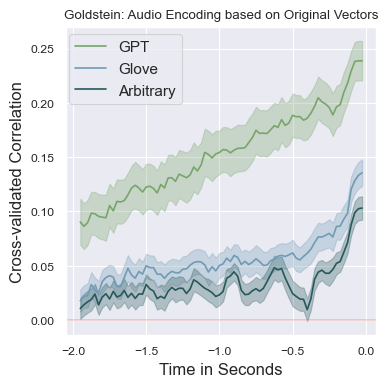

In [12]:
# get model names
models = [k.split(sep='_')[1] for k in results.keys()]
labels = [m for m in models]
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate(results.keys()):
    ax1.plot(times_100[:78], results[key].mean(axis=0).mean(axis=0)[:78], c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100[:78], lowerCI(reshape(results[key]))[:78], 
                                upperCI(reshape(results[key]))[:78], color=colours[models[i]], alpha=0.3)

ax1.legend(loc=(0.01,0.75), fontsize=11)
#ax1.set_ylim([-0.005, 0.05])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+': Audio Encoding based on Original Vectors')

fig_folder = '../figures/supplementary/'

use_regressed_out= False
plot_split = False
top = 1

fig_path = fig_folder+'Acoustics_{}_with_residualised_vectors_{}-prediction_split_{}-top_{}.pdf'.format(dataset,
                                                                                                  use_regressed_out,
                                                                                                  plot_split, 
                                                                                                  top)

plt.savefig(fig_path, format='pdf',bbox_inches='tight')

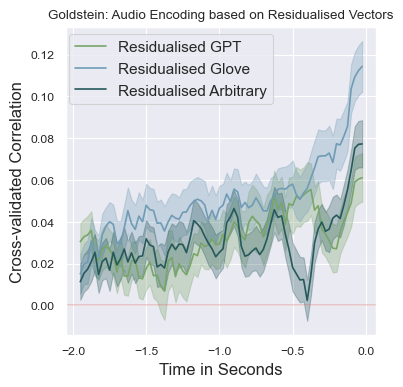

In [13]:
# get model names
models = [k.split(sep='_')[1] for k in results.keys()]
labels = ['Residualised ' + m for m in models]
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate(res_results.keys()):
    ax1.plot(times_100[:78], res_results[key].mean(axis=0).mean(axis=0)[:78], c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100[:78], lowerCI(reshape(res_results[key]))[:78], 
                                upperCI(reshape(res_results[key]))[:78], color=colours[models[i]], alpha=0.3)

ax1.legend(loc=(0.01,0.75), fontsize=11)
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+': Audio Encoding based on Residualised Vectors')

use_regressed_out= True
plot_split = False
top = 1

fig_path = fig_folder+'Acoustics_{}_with_residualised_vectors_{}-prediction_split_{}-top_{}.pdf'.format(dataset,
                                                                                                  use_regressed_out,
                                                                                                  plot_split, 
                                                                                                  top)

plt.savefig(fig_path, format='pdf',bbox_inches='tight')

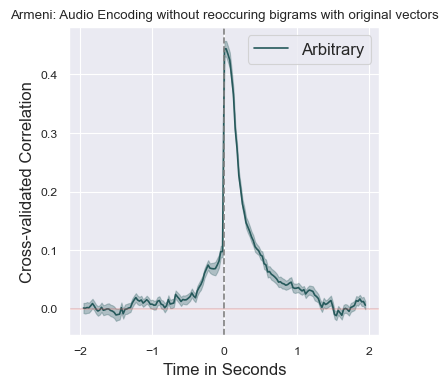

In [28]:
# get model names
models = ['Arbitrary']
labels = models
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_arbitrary_no_bigrams]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend( fontsize=12)
#ax1.set_ylim([-0.005, 0.05])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+': Audio Encoding without reoccuring bigrams with original vectors')

#add dashed vertical line at t=0:
ax1.axvline(x=0, color='gray', linestyle='--')

fig_folder = '../figures/supplementary/'

use_regressed_out = False
plot_split        = False
top               = None

fig_path = fig_folder+'Acoustics_without_reoccuring_bigrams_with_original_vectors_{}-prediction_split_{}-top_{}.pdf'.format(dataset,
                                                                                                  use_regressed_out,
                                                                                                  plot_split, 
                                                                                                  top)

plt.savefig(fig_path, format='pdf',bbox_inches='tight')

### Audio Encoding: The Predictability Effect

In [14]:
# Let's get the information about top predictions:
# ------------------------------------------------

if dataset == 'Goldstein':
    df = pd.read_csv('../Goldstein_gpt_features/transcript_data_gpt.txt', 
                                sep='\t',
                                index_col='Unnamed: 0')
    # first we only want to keep the word-initial token of a word:
    mask_first = df["word_idx"] != df["word_idx"].shift(1)
    df_first   = df[mask_first]

    is_top_1     = [x < 1 for x in df_first['rank']] # rank 0 is the Top-1 prediction
    is_not_top_1 = [not x for x in is_top_1]
    is_top_5     = [x < 5 for x in df_first['rank']] # rank 4 is the Top-5 prediction
    is_not_top_5 = [not x for x in is_top_5]

if dataset == 'Armeni':
    with open('../audio/Armeni/Dataframe_WordSurprisal_Top10Words_All_Sessions.pkl', 'rb') as f:
        df = pickle.load(f)
    is_top_1 = df.is_Top_1.to_list()[:X_Glove.shape[0]]
    is_not_top_1 = [not x for x in is_top_1]
    is_top_5     = df.is_Top_5.to_list()[:X_Glove.shape[0]]
    is_not_top_5 = [not x for x in is_top_5]

print('Top-1:', np.unique(is_top_1, return_counts=True))
print('Top-5:', np.unique(is_top_5, return_counts=True))

Top-1: (array([False,  True]), array([3651, 1485]))
Top-5: (array([False,  True]), array([2532, 2604]))


In [15]:
# Let's add this information to our words dataframe:
words_df['is_top_1'] = is_top_1
words_df['is_top_5'] = is_top_5

words_df['previous word'] = words_df['word'].shift(1)
words_df.iloc[0, words_df.columns.get_loc('previous word')] = ''
words_df['previous bigram'] = words_df['previous word'] + '_' + words_df['word']
words_df['is_bigram'] = words_df.duplicated('previous bigram', keep=False)

words_df.head(6)

,word,onset,offset,duration,duration previous word,PoS,previous PoS,word_index,previous PoS_type,is_top_1,is_top_5,previous word,previous bigram,is_bigram
0,Act,3.710,3.790,0.08,0.00,PROPN,None,0,Non-content,False,False,,_Act,False
1,"one,",3.990,4.190,0.20,0.08,NUM,PROPN,1,Content,False,False,Act,"Act_one,",False
2,monkey,4.651,4.931,0.28,0.20,NOUN,NUM,2,Non-content,False,False,"one,","one,_monkey",False
3,in,4.951,5.011,0.06,0.28,ADP,NOUN,3,Content,False,False,monkey,monkey_in,True
4,the,5.051,5.111,0.06,0.06,DET,ADP,4,Non-content,True,True,in,in_the,True
5,middle.,5.151,5.391,0.24,0.06,NOUN,DET,5,Non-content,True,True,the,the_middle.,False


/var/folders/0s/rfyt86_x3dd79y121cm9vtrr0000gn/T/ipykernel_64125/4114382835.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  counts2 = words_df[~words_df.is_top_1][~words_df.is_bigram]['previous PoS'].value_counts(normalize=True).sort_index() * 100


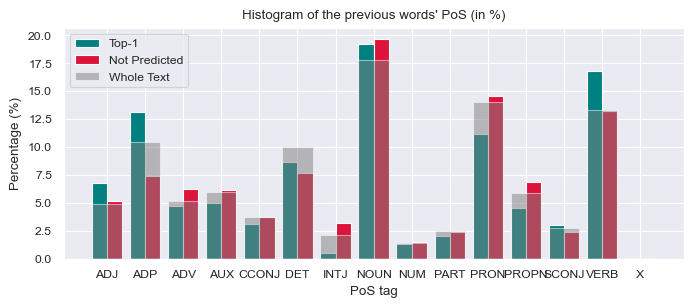

In [16]:

# Count and sort alphabetically, then convert to percentages
counts1 = words_df[words_df.is_top_1]['previous PoS'].value_counts(normalize=True).sort_index() * 100
counts2 = words_df[~words_df.is_top_1][~words_df.is_bigram]['previous PoS'].value_counts(normalize=True).sort_index() * 100
counts3  = words_df['previous PoS'].value_counts(normalize=True).sort_index() * 100

# Combine the index to cover all POS tags
all_tags = counts1.index.union(counts2.index).union(counts3.index)

# Reindex to include all tags, filling missing with 0
counts1 = counts1.reindex(all_tags, fill_value=0)
counts2 = counts2.reindex(all_tags, fill_value=0)
counts3 = counts3.reindex(all_tags, fill_value=0)

# Plot
plt.figure(figsize=(8,3))
width = 0.4
x = range(len(all_tags))

plt.bar([i - width/2 for i in x], counts1, width=width, color='teal', label='Top-1')
plt.bar([i + width/2 for i in x], counts2, width=width, color='crimson', label='Not Predicted')
plt.bar(x, counts3, width=width*2, color='gray', alpha=0.5, label='Whole Text') 

plt.xticks(x, all_tags)
plt.xlabel('PoS tag')
plt.ylabel('Percentage (%)')
plt.title("Histogram of the previous words' PoS (in %)")
plt.legend()
plt.show()

/var/folders/0s/rfyt86_x3dd79y121cm9vtrr0000gn/T/ipykernel_64125/3211608304.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  counts2 = words_df[~words_df.is_top_1][~words_df.is_bigram]['previous PoS_type'].value_counts(normalize=True).sort_index() * 100


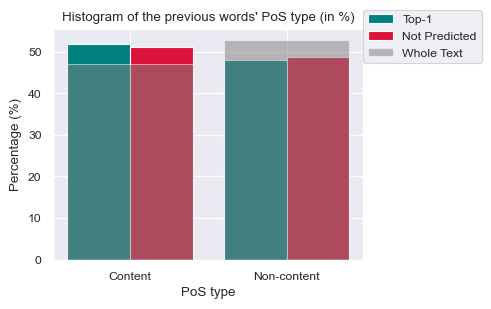

In [17]:

# Count and sort alphabetically, then convert to percentages
counts1 = words_df[words_df.is_top_1]['previous PoS_type'].value_counts(normalize=True).sort_index() * 100
counts2 = words_df[~words_df.is_top_1][~words_df.is_bigram]['previous PoS_type'].value_counts(normalize=True).sort_index() * 100
counts3  = words_df['previous PoS_type'].value_counts(normalize=True).sort_index() * 100

# Combine the index to cover all POS tags
all_tags = counts1.index.union(counts2.index).union(counts3.index)

# Reindex to include all tags, filling missing with 0
counts1 = counts1.reindex(all_tags, fill_value=0)
counts2 = counts2.reindex(all_tags, fill_value=0)
counts3 = counts3.reindex(all_tags, fill_value=0)

# Plot
plt.figure(figsize=(4,3))
width = 0.4
x = range(len(all_tags))

plt.bar([i - width/2 for i in x], counts1, width=width, color='teal', label='Top-1')
plt.bar([i + width/2 for i in x], counts2, width=width, color='crimson', label='Not Predicted')
plt.bar(x, counts3, width=width*2, color='gray', alpha=0.5, label='Whole Text') 

plt.xticks(x, all_tags)
plt.xlabel('PoS type')
plt.ylabel('Percentage (%)')
plt.title("Histogram of the previous words' PoS type (in %)")
plt.legend(loc=(1, 0.85))
plt.show()

/var/folders/0s/rfyt86_x3dd79y121cm9vtrr0000gn/T/ipykernel_64125/2098639208.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  counts2 = words_df[~words_df.is_top_5][~words_df.is_bigram]['previous PoS'].value_counts(normalize=True).sort_index() * 100


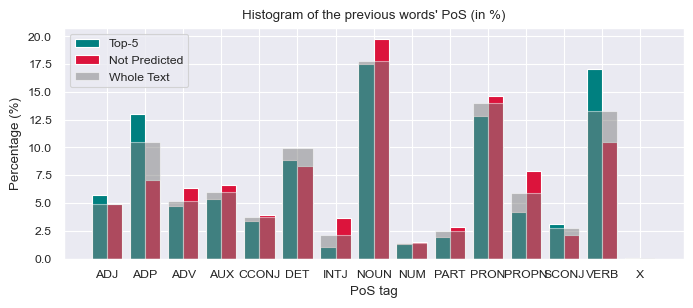

In [18]:

# Count and sort alphabetically, then convert to percentages
counts1 = words_df[words_df.is_top_5]['previous PoS'].value_counts(normalize=True).sort_index() * 100
counts2 = words_df[~words_df.is_top_5][~words_df.is_bigram]['previous PoS'].value_counts(normalize=True).sort_index() * 100
counts3  = words_df['previous PoS'].value_counts(normalize=True).sort_index() * 100

# Combine the index to cover all POS tags
all_tags = counts1.index.union(counts2.index).union(counts3.index)

# Reindex to include all tags, filling missing with 0
counts1 = counts1.reindex(all_tags, fill_value=0)
counts2 = counts2.reindex(all_tags, fill_value=0)
counts3 = counts3.reindex(all_tags, fill_value=0)

# Plot
plt.figure(figsize=(8,3))
width = 0.4
x = range(len(all_tags))

plt.bar([i - width/2 for i in x], counts1, width=width, color='teal', label='Top-5')
plt.bar([i + width/2 for i in x], counts2, width=width, color='crimson', label='Not Predicted')
plt.bar(x, counts3, width=width*2, color='gray', alpha=0.5, label='Whole Text') 

plt.xticks(x, all_tags)
plt.xlabel('PoS tag')
plt.ylabel('Percentage (%)')
plt.title("Histogram of the previous words' PoS (in %)")
plt.legend()
plt.show()

/var/folders/0s/rfyt86_x3dd79y121cm9vtrr0000gn/T/ipykernel_64125/532129478.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  counts2 = words_df[~words_df.is_top_5][~words_df.is_bigram]['previous PoS_type'].value_counts(normalize=True).sort_index() * 100


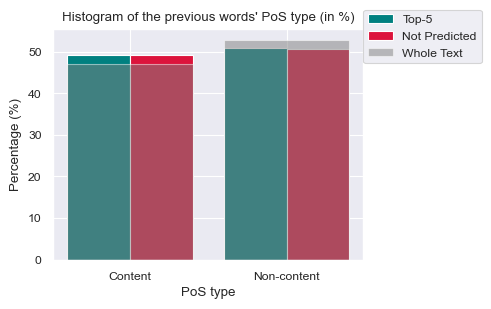

In [19]:

# Count and sort alphabetically, then convert to percentages
counts1 = words_df[words_df.is_top_5]['previous PoS_type'].value_counts(normalize=True).sort_index() * 100
counts2 = words_df[~words_df.is_top_5][~words_df.is_bigram]['previous PoS_type'].value_counts(normalize=True).sort_index() * 100
counts3  = words_df['previous PoS_type'].value_counts(normalize=True).sort_index() * 100

# Combine the index to cover all POS tags
all_tags = counts1.index.union(counts2.index).union(counts3.index)

# Reindex to include all tags, filling missing with 0
counts1 = counts1.reindex(all_tags, fill_value=0)
counts2 = counts2.reindex(all_tags, fill_value=0)
counts3 = counts3.reindex(all_tags, fill_value=0)

# Plot
plt.figure(figsize=(4,3))
width = 0.4
x = range(len(all_tags))

plt.bar([i - width/2 for i in x], counts1, width=width, color='teal', label='Top-5')
plt.bar([i + width/2 for i in x], counts2, width=width, color='crimson', label='Not Predicted')
plt.bar(x, counts3, width=width*2, color='gray', alpha=0.5, label='Whole Text') 

plt.xticks(x, all_tags)
plt.xlabel('PoS type')
plt.ylabel('Percentage (%)')
plt.title("Histogram of the previous words' PoS type (in %)")
plt.legend(loc=(1, 0.85))
plt.show()

#### Since we see that there are differences in PoS types accross the two categories & a difference in the number of trials, which might both affect encoding performance, we account for both in the predictability split:

We do this in the following way:
--------------------------------
1. We compute the PoS distribution in the entire texts 

2. We randomly subsample the Top-1 & Top-5 splits such that they best ressemble the PoS distribution in the whole text. Since this comes with a loss of trials, we try to maximise the number of trials without deviating from the desired PoS distribution by as little as possible in any of the main PoS: Noun, Verb, Adjective etc. The subsampling avoids chucking out locally highly predictable trials, i.e. bigrams in the text

3. The Not-Predicted split is then randomly subsambled such that it has the same number of trials and PoS distribution as the Top-1/Top-5 split

4. This is done for 100 random seeds and averaged 

In [20]:
len(words_df[words_df.is_top_1][words_df.is_bigram]), len(words_df[words_df.is_top_1][~words_df.is_bigram])

/var/folders/0s/rfyt86_x3dd79y121cm9vtrr0000gn/T/ipykernel_64125/3960561059.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(words_df[words_df.is_top_1][words_df.is_bigram]), len(words_df[words_df.is_top_1][~words_df.is_bigram])
/var/folders/0s/rfyt86_x3dd79y121cm9vtrr0000gn/T/ipykernel_64125/3960561059.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(words_df[words_df.is_top_1][words_df.is_bigram]), len(words_df[words_df.is_top_1][~words_df.is_bigram])


(701, 784)

In [21]:
len(words_df[words_df.is_top_5][words_df.is_bigram]), len(words_df[words_df.is_top_5][~words_df.is_bigram])

/var/folders/0s/rfyt86_x3dd79y121cm9vtrr0000gn/T/ipykernel_64125/3836302637.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(words_df[words_df.is_top_5][words_df.is_bigram]), len(words_df[words_df.is_top_5][~words_df.is_bigram])
/var/folders/0s/rfyt86_x3dd79y121cm9vtrr0000gn/T/ipykernel_64125/3836302637.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(words_df[words_df.is_top_5][words_df.is_bigram]), len(words_df[words_df.is_top_5][~words_df.is_bigram])


(1082, 1522)

In [22]:

# Split the dataframe
df_top1     = words_df[words_df['is_top_1']].copy()
df_not_top1 = words_df[~words_df['is_top_1']][~words_df['is_bigram']].copy()

# Set target sizes
if dataset == 'Goldstein':
        target_size_top1     = 800 # this size keeps the PoS distribution fairly balanced (+/- 0.16%)
        target_size_not_top1 = 800
elif dataset == 'Armeni':
        target_size_top1     = 2500
        target_size_not_top1 = 2500
#target_size_not_top1 = target_size_top1 # keep them equal

# get the percentages in the whole text
PoS_percentage_whole_text  = words_df['previous PoS'].value_counts(normalize=True).sort_index() * 100

# Subsample without replacement
sub_top1              = subsample_to_adjust_PoS(df_top1, PoS_percentage_whole_text, target_size_top1, random_state=41, keep_bigrams=True)
PoS_percentage_top1   = sub_top1['previous PoS'].value_counts(normalize=True).sort_index() * 100
sub_not_top1          = subsample_to_adjust_PoS(df_not_top1, PoS_percentage_top1, target_size_not_top1, random_state=41, keep_bigrams=False)

# Check resulting distributions
print(dataset,': \n', '-'*41)
print('\t All \t Top-1 \t Not Top-1  Diff  \n', '-'*41)
for indx, all, top1, not_top1 in zip(words_df['previous PoS'].value_counts(normalize=True).index, 
                                     words_df['previous PoS'].value_counts(normalize=True) * 100, 
                             sub_top1['previous PoS'].value_counts(normalize=True) * 100, 
                             sub_not_top1['previous PoS'].value_counts(normalize=True) * 100):
    print('{}: \t {:.2f} \t {:.2f} \t {:.2f} \t ({:.2f})'.format(indx, all, top1, not_top1, (not_top1-top1)))


Goldstein : 
 -----------------------------------------
	 All 	 Top-1 	 Not Top-1  Diff  
 -----------------------------------------
NOUN: 	 17.76 	 16.57 	 16.67 	 (0.10)
PRON: 	 14.02 	 16.45 	 16.54 	 (0.09)
VERB: 	 13.32 	 13.07 	 13.13 	 (0.06)
ADP: 	 10.48 	 12.37 	 12.37 	 (0.01)
DET: 	 9.99 	 10.15 	 10.23 	 (0.08)
AUX: 	 6.00 	 5.48 	 5.43 	 (-0.05)
PROPN: 	 5.88 	 5.48 	 5.43 	 (-0.05)
ADV: 	 5.14 	 4.78 	 4.80 	 (0.01)
ADJ: 	 4.93 	 4.55 	 4.55 	 (-0.01)
CCONJ: 	 3.76 	 3.62 	 3.54 	 (-0.08)
SCONJ: 	 2.77 	 3.03 	 3.03 	 (-0.00)
PART: 	 2.45 	 2.33 	 2.27 	 (-0.06)
INTJ: 	 2.10 	 1.17 	 1.14 	 (-0.03)
NUM: 	 1.36 	 0.93 	 0.88 	 (-0.05)


/var/folders/0s/rfyt86_x3dd79y121cm9vtrr0000gn/T/ipykernel_64125/1119048781.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_not_top1 = words_df[~words_df['is_top_1']][~words_df['is_bigram']].copy()


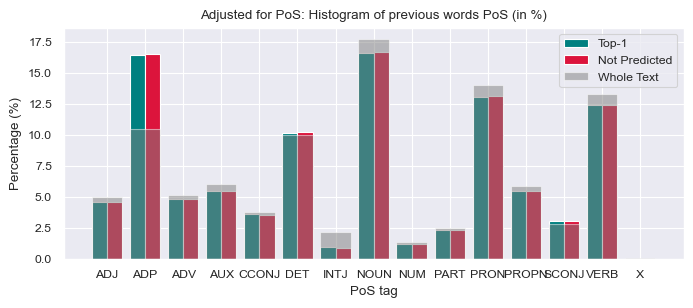

In [23]:

# Count and sort alphabetically, then convert to percentages
counts1 = sub_top1['previous PoS'].value_counts(normalize=True).sort_index() * 100
counts2 = sub_not_top1['previous PoS'].value_counts(normalize=True).sort_index() * 100
counts3  = words_df['previous PoS'].value_counts(normalize=True).sort_index() * 100

# Combine the index to cover all POS tags
all_tags = counts1.index.union(counts2.index).union(counts3.index)

# Reindex to include all tags, filling missing with 0
counts1 = counts1.reindex(all_tags, fill_value=0)
counts2 = counts2.reindex(all_tags, fill_value=0)
counts3 = counts3.reindex(all_tags, fill_value=0)

# Plot
plt.figure(figsize=(8,3))
width = 0.4
x = range(len(all_tags))

plt.bar([i - width/2 for i in x], counts1, width=width, color='teal', label='Top-1')
plt.bar([i + width/2 for i in x], counts2, width=width, color='crimson', label='Not Predicted')
plt.bar(x, counts3, width=width*2, color='gray', alpha=0.5, label='Whole Text') 

plt.xticks(x, all_tags)
plt.xlabel('PoS tag')
plt.ylabel('Percentage (%)')
plt.title('Adjusted for PoS: Histogram of previous words PoS (in %)')
plt.legend()
plt.show()

In [24]:

# Subsample and encode for 100 different random states:
# -----------------------------------------------------

# initialise lists for encodings:
list_top1     = []
list_not_top1 = []

for i in range(100):
    # Subsample without replacement
    sub_top1     = subsample_to_adjust_PoS(df_top1, PoS_percentage_whole_text, target_size_top1, random_state=i, keep_bigrams=True)
    PoS_percentage_top1   = sub_top1['previous PoS'].value_counts(normalize=True).sort_index() * 100
    sub_not_top1 = subsample_to_adjust_PoS(df_not_top1, PoS_percentage_top1, target_size_not_top1, random_state=i, keep_bigrams=False)

    # get the indices:
    indx_top_1     = sub_top1.word_index.to_numpy().astype(int)
    indx_not_top_1 = sub_not_top1.word_index.to_numpy().astype(int)

    # split and format the y matrix:
    y           = y_acoustics
    y_top_1     = y[indx_top_1]
    y_not_top_1 = y[indx_not_top_1]
    y_top_1     = np.swapaxes(np.swapaxes(y_top_1, 1, 2), 0, 1)
    y_not_top_1 = np.swapaxes(np.swapaxes(y_not_top_1, 1, 2), 0, 1)

    # split the X_Glove matrix
    X_Glove_top_1     = X_Glove[indx_top_1]
    X_Glove_not_top_1 = X_Glove[indx_not_top_1]


    # compute the encoding of the acoustics for each split
    encoding_Glove_top_1     = brainscore(X_Glove_top_1, y_top_1)
    encoding_Glove_not_top_1 = brainscore(X_Glove_not_top_1, y_not_top_1)

    list_top1.append(encoding_Glove_top_1)
    list_not_top1.append(encoding_Glove_not_top_1)

# concatenate along the 1st axis since our plotting routing reshapes the data anyway but expects 3 dimensions
encoding_Glove_top_1     = np.concatenate(list_top1, axis=0)
encoding_Glove_not_top_1 = np.concatenate(list_not_top1, axis=0)

encoding_Glove_top_1.shape

We are now in the brainscore method, and y has shape:
(9, 857, 157)
We are now in the brainscore method, and y has shape:
(9, 792, 157)
We are now in the brainscore method, and y has shape:
(9, 857, 157)
We are now in the brainscore method, and y has shape:
(9, 792, 157)
We are now in the brainscore method, and y has shape:
(9, 857, 157)
We are now in the brainscore method, and y has shape:
(9, 792, 157)
We are now in the brainscore method, and y has shape:
(9, 857, 157)
We are now in the brainscore method, and y has shape:
(9, 792, 157)
We are now in the brainscore method, and y has shape:
(9, 857, 157)
We are now in the brainscore method, and y has shape:
(9, 792, 157)
We are now in the brainscore method, and y has shape:
(9, 857, 157)
We are now in the brainscore method, and y has shape:
(9, 792, 157)
We are now in the brainscore method, and y has shape:
(9, 857, 157)
We are now in the brainscore method, and y has shape:
(9, 792, 157)
We are now in the brainscore method, and y has s

(900, 10, 157)

Text(0.5, 1.0, 'Goldstein Audio Encoding: \n PoS adjusted: Original Vectors Top 1')

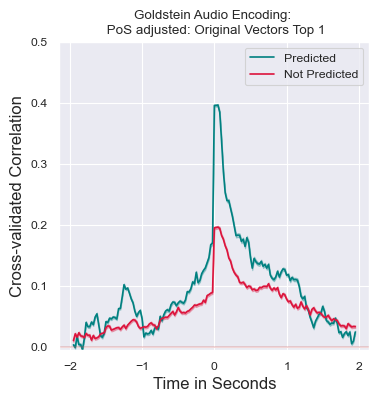

In [25]:
models = ['Top 1', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_top_1, encoding_Glove_not_top_1]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.5])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: \n PoS adjusted: Original Vectors ' + models[0])

Text(0.5, 1.0, 'Goldstein Audio Encoding: \n PoS adjusted: Original Vectors Top 1')

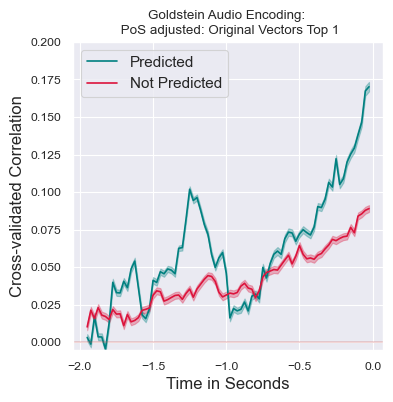

In [26]:
models = ['Top 1', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_top_1, encoding_Glove_not_top_1]):
    ax1.plot(times_100[:78], key.mean(axis=0).mean(axis=0)[:78], c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100[:78], lowerCI(reshape(key))[:78], 
                                upperCI(reshape(key))[:78], color=colours[models[i]], alpha=0.3)

ax1.legend(fontsize=11)
ax1.set_ylim([-0.005, 0.2])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: \n PoS adjusted: Original Vectors ' + models[0])

...now let's do this for the Top-5 split


In [27]:

# Split the dataframe
df_top5     = words_df[words_df['is_top_5']].copy()
df_not_top5 = words_df[~words_df['is_top_5']][~words_df['is_bigram']].copy()

# Set target sizes
if dataset == 'Goldstein':
        target_size_top5     = 1500 # this number keeps the PoS distribution balanced (+/- 0.1%)
elif dataset == 'Armeni':
        target_size_top5     = 2500 # this number keeps the PoS distribution balanced (+/- 0.1%)
target_size_not_top5 = target_size_top5 # keep them equal

# get the percentages in the whole text
PoS_percentage_whole_text  = words_df['previous PoS'].value_counts(normalize=True).sort_index() * 100

# Subsample without replacement
sub_top5     = subsample_to_adjust_PoS(df_top5, PoS_percentage_whole_text, target_size_top5, random_state=31, keep_bigrams=True)
PoS_percentage_top5   = sub_top5['previous PoS'].value_counts(normalize=True).sort_index() * 100
sub_not_top5 = subsample_to_adjust_PoS(df_not_top5, PoS_percentage_top5, target_size_not_top5, random_state=31, keep_bigrams=False)

# Check resulting distributions
print(dataset,': \n', '-'*41)
print('\t All \t Top-5 \t Not Top-5  Diff  \n', '-'*41)
for indx, all, top5, not_top5 in zip(words_df['previous PoS'].value_counts(normalize=True).index, 
                                     words_df['previous PoS'].value_counts(normalize=True) * 100, 
                             sub_top5['previous PoS'].value_counts(normalize=True) * 100, 
                             sub_not_top5['previous PoS'].value_counts(normalize=True) * 100):
    print('{}: \t {:.2f} \t {:.2f} \t {:.2f} \t ({:.2f})'.format(indx, all, top5, not_top5, (not_top5-top5)))

Goldstein : 
 -----------------------------------------
	 All 	 Top-5 	 Not Top-5  Diff  
 -----------------------------------------
NOUN: 	 17.76 	 17.12 	 18.02 	 (0.90)
PRON: 	 14.02 	 14.41 	 14.22 	 (-0.20)
VERB: 	 13.32 	 13.51 	 13.51 	 (-0.00)
ADP: 	 10.48 	 12.81 	 10.13 	 (-2.67)
DET: 	 9.99 	 9.59 	 10.06 	 (0.48)
AUX: 	 6.00 	 5.73 	 5.98 	 (0.25)
PROPN: 	 5.88 	 5.66 	 5.91 	 (0.25)
ADV: 	 5.14 	 4.95 	 5.21 	 (0.25)
ADJ: 	 4.93 	 4.70 	 4.93 	 (0.23)
CCONJ: 	 3.76 	 3.60 	 3.80 	 (0.20)
SCONJ: 	 2.77 	 2.64 	 2.74 	 (0.11)
PART: 	 2.45 	 2.32 	 2.39 	 (0.08)
INTJ: 	 2.10 	 1.67 	 1.76 	 (0.09)
NUM: 	 1.36 	 1.29 	 1.34 	 (0.05)


/var/folders/0s/rfyt86_x3dd79y121cm9vtrr0000gn/T/ipykernel_64125/2797897607.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_not_top5 = words_df[~words_df['is_top_5']][~words_df['is_bigram']].copy()


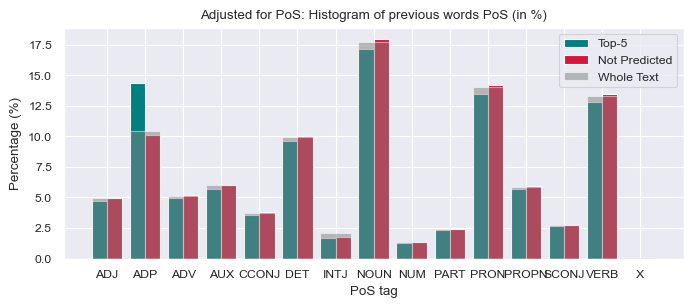

In [28]:

# Count and sort alphabetically, then convert to percentages
counts1 = sub_top5['previous PoS'].value_counts(normalize=True).sort_index() * 100
counts2 = sub_not_top5['previous PoS'].value_counts(normalize=True).sort_index() * 100
counts3  = words_df['previous PoS'].value_counts(normalize=True).sort_index() * 100

# Combine the index to cover all POS tags
all_tags = counts1.index.union(counts2.index).union(counts3.index)

# Reindex to include all tags, filling missing with 0
counts1 = counts1.reindex(all_tags, fill_value=0)
counts2 = counts2.reindex(all_tags, fill_value=0)
counts3 = counts3.reindex(all_tags, fill_value=0)

# Plot
plt.figure(figsize=(8,3))
width = 0.4
x = range(len(all_tags))

plt.bar([i - width/2 for i in x], counts1, width=width, color='teal', label='Top-5')
plt.bar([i + width/2 for i in x], counts2, width=width, color='crimson', label='Not Predicted')
plt.bar(x, counts3, width=width*2, color='gray', alpha=0.5, label='Whole Text') 

plt.xticks(x, all_tags)
plt.xlabel('PoS tag')
plt.ylabel('Percentage (%)')
plt.title('Adjusted for PoS: Histogram of previous words PoS (in %)')
plt.legend()
plt.show()

In [30]:

# Subsample and encode for 100 different random states:
# -----------------------------------------------------

# initialise lists for encodings:
list_top5     = []
list_not_top5 = []

for i in range(100):
    # Subsample without replacement
    sub_top5     = subsample_to_adjust_PoS(df_top5, PoS_percentage_whole_text, target_size_top5, random_state=i, keep_bigrams=True)
    sub_not_top5 = subsample_to_adjust_PoS(df_not_top5, PoS_percentage_whole_text, target_size_not_top5, random_state=i, keep_bigrams=False)

    # get the indices:
    indx_top_5     = sub_top5.word_index.to_numpy().astype(int)
    indx_not_top_5 = sub_not_top5.word_index.to_numpy().astype(int)

    # split and format the y matrix:
    y           = y_acoustics
    y_top_5     = y[indx_top_5]
    y_not_top_5 = y[indx_not_top_5]
    y_top_5     = np.swapaxes(np.swapaxes(y_top_5, 1, 2), 0, 1)
    y_not_top_5 = np.swapaxes(np.swapaxes(y_not_top_5, 1, 2), 0, 1)

    # split the X_Glove matrix
    X_Glove_top_5     = X_Glove[indx_top_5]
    X_Glove_not_top_5 = X_Glove[indx_not_top_5]


    # compute the encoding of the acoustics for each split
    encoding_Glove_top_5     = brainscore(X_Glove_top_5, y_top_5)
    encoding_Glove_not_top_5 = brainscore(X_Glove_not_top_5, y_not_top_5)

    list_top5.append(encoding_Glove_top_5)
    list_not_top5.append(encoding_Glove_not_top_5)

# concatenate along the 1st axis since our plotting routing reshapes the data anyway but expects 3 dimensions
encoding_Glove_top_5     = np.concatenate(list_top5, axis=0)
encoding_Glove_not_top_5 = np.concatenate(list_not_top5, axis=0)
encoding_Glove_top_5.shape

We are now in the brainscore method, and y has shape:
(9, 1554, 157)
We are now in the brainscore method, and y has shape:
(9, 1480, 157)
We are now in the brainscore method, and y has shape:
(9, 1554, 157)
We are now in the brainscore method, and y has shape:
(9, 1480, 157)
We are now in the brainscore method, and y has shape:
(9, 1554, 157)
We are now in the brainscore method, and y has shape:
(9, 1480, 157)
We are now in the brainscore method, and y has shape:
(9, 1554, 157)
We are now in the brainscore method, and y has shape:
(9, 1480, 157)
We are now in the brainscore method, and y has shape:
(9, 1554, 157)
We are now in the brainscore method, and y has shape:
(9, 1480, 157)
We are now in the brainscore method, and y has shape:
(9, 1554, 157)
We are now in the brainscore method, and y has shape:
(9, 1480, 157)
We are now in the brainscore method, and y has shape:
(9, 1554, 157)
We are now in the brainscore method, and y has shape:
(9, 1480, 157)
We are now in the brainscore metho

(900, 10, 157)

Text(0.5, 1.0, 'Goldstein Audio Encoding: \n PoS adjusted: Original Vectors Top 5')

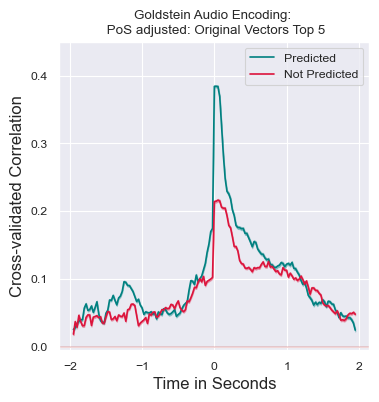

In [31]:
models = ['Top 5', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_top_5, encoding_Glove_not_top_5]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.45])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: \n PoS adjusted: Original Vectors ' + models[0])

Text(0.5, 1.0, 'Goldstein Audio Encoding: \n PoS adjusted: Original Vectors Top 5')

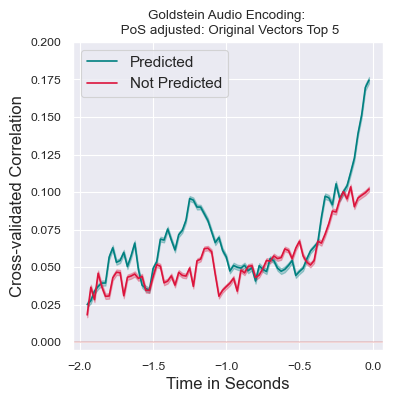

In [ ]:
models = ['Top 5', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_top_5, encoding_Glove_not_top_5]):
    ax1.plot(times_100[:78], key.mean(axis=0).mean(axis=0)[:78], c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100[:78], lowerCI(reshape(key))[:78], 
                                upperCI(reshape(key))[:78], color=colours[models[i]], alpha=0.3)

ax1.legend(fontsize=11)
ax1.set_ylim([-0.005, 0.2])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: \n PoS adjusted: Original Vectors ' + models[0])

### Now we look at residualised GloVe vectors:

In [32]:
print(y.shape)

(5136, 157, 9)


In [33]:

# Subsample and encode for 100 different random states:
# -----------------------------------------------------

# initialise lists for encodings:
list_top1_residualised     = []
list_not_top1_residualised = []

for i in range(100):
    # Subsample without replacement
    sub_top1     = subsample_to_adjust_PoS(df_top1, PoS_percentage_whole_text, target_size_top1, random_state=i, keep_bigrams=True)
    PoS_percentage_top1   = sub_top1['previous PoS'].value_counts(normalize=True).sort_index() * 100
    sub_not_top1 = subsample_to_adjust_PoS(df_not_top1, PoS_percentage_top1, target_size_not_top1, random_state=i, keep_bigrams=False)


    # make sure y is still 
    y  = y_acoustics # we do not drop the 1st epoch since it's inside the new method
    y  = np.swapaxes(np.swapaxes(y, 1, 2), 0, 1)
    print(y.shape)

    # compute the encoding of the acoustics for each split
    encoding_Glove_residualised_top_1     = brainscore(X_Glove, y, indx_top_1 = indx_top_1)
    encoding_Glove_residualised_not_top_1 = brainscore(X_Glove, y, indx_top_1 = indx_not_top_1)

    list_top1_residualised.append(encoding_Glove_residualised_top_1)
    list_not_top1_residualised.append(encoding_Glove_residualised_not_top_1)

# concatenate along the 1st axis since our plotting routing reshapes the data anyway but expects 3 dimensions
encoding_Glove_residualised_top_1     = np.concatenate(list_top1_residualised, axis=0)
encoding_Glove_residualised_not_top_1 = np.concatenate(list_not_top1_residualised, axis=0)
encoding_Glove_residualised_top_1.shape

(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157

(900, 10, 157)

Text(0.5, 1.0, 'Goldstein Audio Encoding: \n PoS adjusted: Residualised Vectors Top 1')

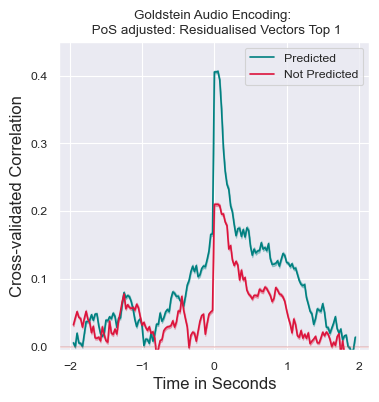

In [34]:
models = ['Top 1', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_residualised_top_1, encoding_Glove_residualised_not_top_1]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.45])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: \n PoS adjusted: Residualised Vectors ' + models[0])

Text(0.5, 1.0, 'Goldstein Audio Encoding: \n PoS adjusted: Residualised Vectors Top 1')

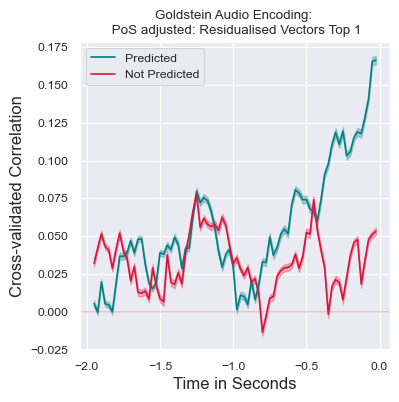

In [37]:
models = ['Top 1', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_residualised_top_1, encoding_Glove_residualised_not_top_1]):
    ax1.plot(times_100[:78], key.mean(axis=0).mean(axis=0)[:78], c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100[:78], lowerCI(reshape(key))[:78], 
                                upperCI(reshape(key))[:78], color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: \n PoS adjusted: Residualised Vectors ' + models[0])

In [38]:

# Subsample and encode for 100 different random states:
# -----------------------------------------------------

# initialise lists for encodings:
list_top5_residualised     = []
list_not_top5_residualised = []

for i in range(100):
    # Subsample without replacement
    sub_top5     = subsample_to_adjust_PoS(df_top5, PoS_percentage_whole_text, target_size_top5, random_state=i, keep_bigrams=True)
    PoS_percentage_top5   = sub_top5['previous PoS'].value_counts(normalize=True).sort_index() * 100
    sub_not_top5 = subsample_to_adjust_PoS(df_not_top5, PoS_percentage_top5, target_size_not_top5, random_state=i, keep_bigrams=False)


    # make sure y is still 
    y  = y_acoustics # we do not drop the 1st epoch since it's inside the new method
    y  = np.swapaxes(np.swapaxes(y, 1, 2), 0, 1)
    print(y.shape)

    # compute the encoding of the acoustics for each split
    encoding_Glove_residualised_top_5     = brainscore(X_Glove, y, indx_top_1 = indx_top_5)
    encoding_Glove_residualised_not_top_5 = brainscore(X_Glove, y, indx_top_1 = indx_not_top_5)

    list_top5_residualised.append(encoding_Glove_residualised_top_5)
    list_not_top5_residualised.append(encoding_Glove_residualised_not_top_5)

# concatenate along the 1st axis since our plotting routing reshapes the data anyway but expects 3 dimensions
encoding_Glove_residualised_top_5     = np.concatenate(list_top5_residualised, axis=0)
encoding_Glove_residualised_not_top_5 = np.concatenate(list_not_top5_residualised, axis=0)
encoding_Glove_residualised_top_5.shape

(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157)
(9, 5136, 157)
We are now in the brainscore method, and y has shape:
(9, 5136, 157

(900, 10, 157)

Text(0.5, 1.0, 'Goldstein Audio Encoding: \n PoS adjusted: Residualised Vectors Top 5')

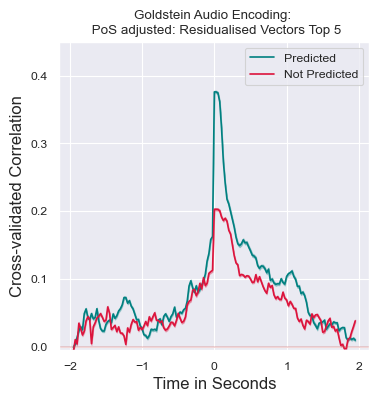

In [39]:
models = ['Top 5', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_residualised_top_5, encoding_Glove_residualised_not_top_5]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.45])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: \n PoS adjusted: Residualised Vectors ' + models[0])

Text(0.5, 1.0, 'Goldstein Audio Encoding: \n PoS adjusted: Residualised Vectors Top 5')

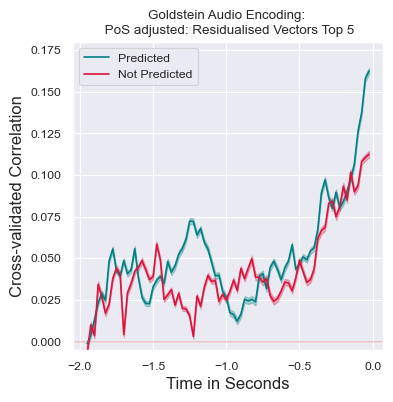

In [43]:
models = ['Top 5', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_residualised_top_5, encoding_Glove_residualised_not_top_5]):
    ax1.plot(times_100[:78], key.mean(axis=0).mean(axis=0)[:78], c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100[:78], lowerCI(reshape(key))[:78], 
                                upperCI(reshape(key))[:78], color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.18])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: \n PoS adjusted: Residualised Vectors ' + models[0])